# Birds-eye idea

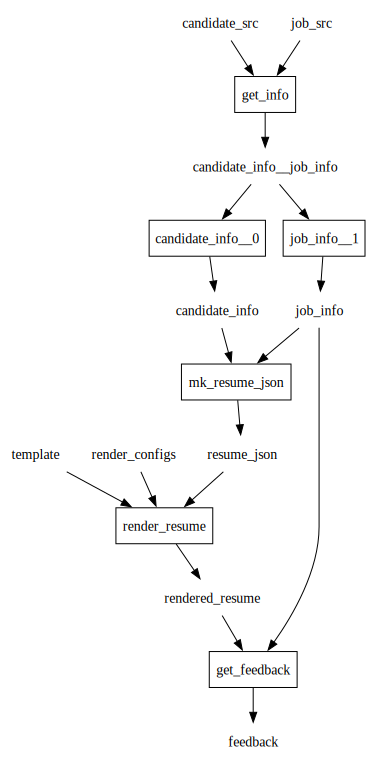

In [8]:
from meshed import code_to_dag


@code_to_dag
def ai_resume_agent():
    # # from some job source, for example, a job description, create a job info object
    # # this job_info object is often just an aggregate string of all the information found 
    # # about the job. 
    # # for example the job_src could be the file path or a URL pointing to a job description,
    # # and then, the get_job_info function with analyze it, go fetch more information on the company,
    # # it's people, it's products and services, and anything that may be useful to decide on 
    # # what candidate characteristics are important to highlight in a resume.
    # # The job_src may optionally include some further free form information or instructions that 
    # # are given to the get_job_info process. 
    # # The simplest get_job_info would be to just figure out how to read the job_src and 
    # # return the text content for it. 
    # # The more complex get_job_info would be to do a lot of research on the job description
    # # and the company, and return a very detailed job_info object.
    # job_info = get_job_info(job_src)

    # # Use the job_info object to extract relevant information for the candidate to highlight
    # # in their resume. 
    # # The simplest of get_candidate_info would ignore the job_info and just return what
    # # ever text information is associated to the candidate_src.
    # # The more complex get_candidate_info would act as an agentic RAG process that
    # # would use the job_info to decide what information to extract from a more significant
    # # candidate_src, which could be a resume file, a LinkedIn profile URL, a GitHub profile URL,
    # candidate_info = get_candidate_info(candidate_src, job_info)

    candidate_info, job_info = get_info(candidate_src, job_src)

    resume_json = mk_resume_json(candidate_info, job_info)
    rendered_resume = render_resume(resume_json, template, render_configs)
    feedback = get_feedback(rendered_resume, job_info)

ai_resume_agent.dot_digraph()

# Rendering

In [3]:
from pathlib import Path
import json

from hired.util import data_files, resume_json_example
from hired.tools import mk_resume
from hired.base import RenderingConfig

# Source and target locations (packaged data_files by default)
resume_path = resume_json_example  # Path object pointing at the packaged JSON
out_dir = data_files / 'resume_renderings'
out_dir.mkdir(parents=True, exist_ok=True)

# Load the resume dict
resume = json.loads(resume_path.read_text())

# 1) Render to nice HTML using a packaged theme (e.g. 'startbootstrap')
html_bytes = mk_resume(resume, RenderingConfig(format='html', theme='startbootstrap'))
html_path = out_dir / 'test_resume_html_startbootstrap.html'
html_path.write_bytes(html_bytes)

# 2) Render to PDF using the same theme. If WeasyPrint is installed you'll
# get a styled PDF; otherwise the library falls back to a minimal PDF builder.
pdf_bytes = mk_resume(resume, RenderingConfig(format='pdf', theme='startbootstrap'))
pdf_path = out_dir / 'test_resume_pdf_startbootstrap.pdf'
pdf_path.write_bytes(pdf_bytes)

# 3) Render to Markdown — two options:
#   a) Use mk_resume with a custom template name that produces markdown (if
#      your theme provides a .j2.md template), or
#   b) Use a small inline Jinja template that emits markdown and render via
#      HTMLRenderer.from_string (advanced). Example (a):
md_bytes = mk_resume(resume, RenderingConfig(format='html', theme='elegant', custom_template='Header.j2.md'))
md_path = out_dir / 'test_resume_md_elegant.md'
md_path.write_bytes(md_bytes)

# 4) Parametrizations you may want to try
# - Change the `theme` to any available theme (list available via ThemeRegistry).
# - Pass `custom_css` (string) in RenderingConfig to override or augment theme CSS
#   for PDF rendering.
# - Use `custom_template` to point at a template file (absolute path) or a
#   template name found in the theme folder (relative name).
# - Use your own output path by replacing `out_dir` with any Path you control.

print('Saved examples to', out_dir)

Saved examples to /Users/thorwhalen/Dropbox/py/proj/t/hired/hired/data/resume_renderings


In [2]:
out_dir

PosixPath('/Users/thorwhalen/Dropbox/py/proj/t/hired/hired/data/resume _renderings')

# Refresh json schema, pydantic models and test example

In [ ]:
from hired.util import refresh_resume_schema

# refresh_resume_schema()

Get the schema (dict) from the url
Make pydantic models (code) from it
Replace the code that is in resumejson_pydantic_models.py
Writing the schema in the schema file (for reference)...
Refresh test json
Replace the code that is in resumejson_pydantic_models.py
Writing the schema in the schema file (for reference)...
Refresh test json


# Validation with nice messages

In [9]:
from hired.util import validate_resume_content_dict, ensure_dict

In [10]:
from ju.pydantic_util import schema_to_pydantic_model, extract_friendly_errors, ValidationError


In [11]:
from hired.util import DFLT_RESUME_SCHEMA_PATH, resume_json_example, extract_friendly_errors, ValidationErrorType
import json

from hired import ResumeSchema

content = json.loads(resume_json_example.read_text())
try:
    schema = ResumeSchema(**content)
except Exception as e:
    for field, message in extract_friendly_errors(e):
        print(f"Error in field '{field}': {message}")
    raise

In [16]:
print(resume_json_example)

/Users/thorwhalen/Dropbox/py/proj/t/hired/hired/data/resume_jsons/test_resume.json


In [1]:
from hired.util import resume_json_example, ResumeSchema
from pathlib import Path
import json 

resume_json_example
content = json.loads(resume_json_example.read_text())
resume = ResumeSchema(**content)

import hired

dir(hired)

Path('~/Downloads/example_resume.pdf').expanduser().write_bytes(hired.mk_resume(content))


9610

In [12]:
from pathlib import Path 
f = '/Users/thorwhalen/Dropbox/py/proj/t/hired/hired/tests/fixtures/real_example_resume.json'
content = json.loads(Path(f).read_text())
resume = ResumeSchema(**content)

import hired

dir(hired)

Path('~/Downloads/example_resume.pdf').expanduser().write_bytes(hired.mk_resume(content))

11348

# ResuLLMe

In [ ]:
import contaix 

# b = contaix.get_github.files('https://github.com/IvanIsCoding/ResuLLMe')

Cloning into '/var/folders/mc/c070wfh51kxd9lft8dl74q1r0000gn/T/tmp6mlkjcte'...
& is not a valid attribute name: .gitattributes:2


In [8]:
import json
import os
import shutil
import tempfile
import subprocess
import pathlib
import sys
import functools
import jinja2



## src/doc_utils.py

def escape_for_latex(data):
    if isinstance(data, dict):
        new_data = {}
        for key in data.keys():
            new_data[key] = escape_for_latex(data[key])
        return new_data
    elif isinstance(data, list):
        return [escape_for_latex(item) for item in data]
    elif isinstance(data, str):
        # Adapted from https://stackoverflow.com/q/16259923
        latex_special_chars = {
            "&": r"\&",
            "%": r"\%",
            "$": r"\$",
            "#": r"\#",
            "_": r"\_",
            "{": r"\{",
            "}": r"\}",
            "~": r"\textasciitilde{}",
            "^": r"\^{}",
            "\\": r"\textbackslash{}",
            "\n": "\\newline%\n",
            "-": r"{-}",
            "\xA0": "~",  # Non-breaking space
            "[": r"{[}",
            "]": r"{]}",
        }
        return "".join([latex_special_chars.get(c, c) for c in data])

    return data




# --- TECTONIC RENDERER ---
# This part is a simplified version of the rendering logic from src/render/__init__.py

@functools.lru_cache(maxsize=None)
def find_tectonic_executable():
    """Finds the Tectonic executable. Simplified for this example."""
    return "tectonic"

def render_latex(latex_data, template_name):
    """
    Renders a LaTeX string to a PDF using Tectonic.
    
    Args:
        latex_data (str): The LaTeX document as a string.
        template_name (str): The name of the template used to find supporting files.
    """
    # This is a simplified version of the template commands found in src/templates/__init__.py
    latex_command = ["tectonic", "-X", "compile", "-Z", "continue-on-errors", "--untrusted", "--only-cached", "resume.tex"]
    src_path = os.path.join(os.path.dirname(__file__), f"templates/{template_name}")
    
    with tempfile.TemporaryDirectory() as tmpdirname:
        # Copy auxiliary files from the template directory to a temporary one
        shutil.copytree(src_path, tmpdirname, dirs_exist_ok=True)
        
        # Write LaTeX data to a file
        with open(f"{tmpdirname}/resume.tex", "w") as f:
            f.write(latex_data)
        
        # Determine the tectonic path (simplified)
        tectonic_path = find_tectonic_executable()
        latex_command[0] = tectonic_path

        # Run tectonic command to compile the PDF
        latex_process = subprocess.Popen(
            latex_command, cwd=tmpdirname
        )
        latex_process.wait()

        # Read the generated PDF data
        with open(f"{tmpdirname}/resume.pdf", "rb") as f:
            pdf_data = f.read()

    return pdf_data

# --- JINJA TEMPLATER ---
# This part is a simplified version of the logic from src/templates/__init__.py

def generate_latex(template_name, json_resume, section_ordering):
    """
    Generates a LaTeX string from a JSON resume using Jinja templates.

    Args:
        template_name (str): The name of the template to use (e.g., "Simple").
        json_resume (dict): The resume data in JSON format.
        section_ordering (list): A list of section names in the desired order.
    """
    dir_path = os.path.dirname(os.path.realpath(__file__))
    
    latex_jinja_env = jinja2.Environment(
        block_start_string=r"\BLOCK{",
        block_end_string="}",
        variable_start_string=r"\VAR{",
        variable_end_string="}",
        comment_start_string=r"\#{",
        comment_end_string="}",
        line_statement_prefix="%-",
        line_comment_prefix="%#",
        trim_blocks=True,
        autoescape=False,
        loader=jinja2.FileSystemLoader(os.path.join(dir_path, "templates")),
    )
    
    # Escape special characters for LaTeX
    escaped_json_resume = escape_for_latex(json_resume)
    
    # Load and render individual section templates
    template_paths = {
        "basics": f"{template_name}/basics.tex.jinja",
        "education": f"{template_name}/education.tex.jinja",
        "work": f"{template_name}/work.tex.jinja",
        "skills": f"{template_name}/skills.tex.jinja",
        "projects": f"{template_name}/projects.tex.jinja",
        "awards": f"{template_name}/awards.tex.jinja",
    }
    
    sections = {}
    for section_name, template_path in template_paths.items():
        if section_name in escaped_json_resume:
            template = latex_jinja_env.get_template(template_path)
            # Special handling for 'basics' section to separate first and last name
            if section_name == "basics":
                name_parts = escaped_json_resume["basics"].get("name", "").split(" ")
                firstName = name_parts[0] if name_parts else ""
                lastName = " ".join(name_parts[1:]) if len(name_parts) > 1 else ""
                sections[section_name] = template.render(
                    firstName=firstName, lastName=lastName, **escaped_json_resume["basics"]
                )
            else:
                # Handle other sections dynamically
                template_data = escaped_json_resume.get(section_name)
                # Use a pluralized key for consistency with templates
                plural_key = section_name if section_name != 'basics' else None
                if plural_key:
                    sections[section_name] = template.render(
                        **{plural_key: template_data, "heading": plural_key.capitalize()}
                    )

    # Combine all rendered sections into the main resume template
    resume_template = latex_jinja_env.get_template(f"{template_name}/resume.tex.jinja")
    
    return resume_template.render(sections=sections, section_ordering=section_ordering)


# --- MAIN FUNCTION ---
def generate_resume_pdf(json_data, template_name="Simple", section_ordering=None):
    """
    Generates a PDF resume from a JSON dictionary.

    Args:
        json_data (dict): The resume data as a Python dictionary.
        template_name (str): The name of the template (e.g., "Simple").
        section_ordering (list): Optional list of section names for custom ordering.
    """
    if section_ordering is None:
        section_ordering = ["basics", "education", "work", "skills", "projects", "awards"]

    # 1. Generate the LaTeX source from the JSON data
    latex_resume = generate_latex(template_name, json_data, section_ordering)
    
    # 2. Render the LaTeX source to a PDF
    pdf_bytes = render_latex(latex_resume, template_name)
    
    return pdf_bytes

def generate_resume_from_file(json_filepath, template_name="Simple"):
    """
    Loads JSON from a file and generates a PDF resume.
    
    Args:
        json_filepath (str): Path to the JSON file.
        template_name (str): The name of the template (e.g., "Simple").
    """
    with open(json_filepath, 'r') as f:
        json_data = json.load(f)
    
    return generate_resume_pdf(json_data, template_name)

# --- EXAMPLE USAGE ---
if __name__ == '__main__':
    # Example JSON dictionary
    sample_json = {
        "basics": {
            "name": "Jane Doe",
            "email": "jane.doe@example.com",
            "phone": "555-123-4567",
            "website": "jane-doe.com",
            "address": "123 Main St, Anytown, USA",
        },
        "education": [
            {
                "institution": "University of Somewhere",
                "area": "Computer Science",
                "studyType": "Master of Science",
                "startDate": "2022-09-01",
                "endDate": "2024-05-31",
                "location": "Anytown, USA"
            }
        ],
        "work": [
            {
                "company": "Tech Corp",
                "position": "Software Engineer",
                "startDate": "2024-06-01",
                "endDate": "Present",
                "location": "Anycity, USA",
                "highlights": [
                    "Developed and maintained scalable web applications.",
                    "Collaborated with cross-functional teams to deliver new features."
                ]
            }
        ],
        "skills": [
            {
                "name": "Programming Languages",
                "keywords": ["Python", "JavaScript", "C++"]
            }
        ],
        "projects": [],
        "awards": []
    }

    # Generate PDF from a Python dictionary
    print("Generating PDF from dictionary...")
    pdf_bytes_dict = generate_resume_pdf(sample_json)
    with open("resume_from_dict.pdf", "wb") as f:
        f.write(pdf_bytes_dict)
    print("PDF saved as 'resume_from_dict.pdf'")

    # You would need a real JSON file for this part.
    # For demonstration, let's create a temporary one.
    json_filename = "temp_resume.json"
    with open(json_filename, "w") as f:
        json.dump(sample_json, f, indent=4)

    # Generate PDF from a JSON file
    print(f"Generating PDF from file '{json_filename}'...")
    pdf_bytes_file = generate_resume_from_file(json_filename)
    with open("resume_from_file.pdf", "wb") as f:
        f.write(pdf_bytes_file)
    print("PDF saved as 'resume_from_file.pdf'")

    # Clean up the temporary JSON file
    os.remove(json_filename)

Generating PDF from dictionary...


NameError: name '__file__' is not defined

# Validation

In [ ]:
import graze


In [ ]:
from typing import Any, Dict
import urllib
from ju.pydantic_util import pydantic_model_to_code
import graze 
from hired.util import ensure_dict


DFLT_SCHEMA_URL = (
    "https://raw.githubusercontent.com/jsonresume/resume-schema/v1.0.0/schema.json"
)


jdict = graze.graze(DFLT_SCHEMA_URL)

In [6]:
print(graze.url_to_localpath(DFLT_SCHEMA_URL))

https/raw.githubusercontent.com_f/jsonresume_f/resume-schema_f/v1.0.0_f/schema.json


b'{\n  "$schema": "http://json-schema.org/draft-04/schema#",\n  "additionalProperties": false,\n  "definitions": {\n    "iso8601": {\n      "type": "string",\n      "description": "e.g. 2014-06-29",\n      "pattern": "^([1-2][0-9]{3}-[0-1][0-9]-[0-3][0-9]|[1-2][0-9]{3}-[0-1][0-9]|[1-2][0-9]{3})$"\n    }\n  },\n  "properties": {\n    "$schema": {\n      "type": "string",\n      "description": "link to the version of the schema that can validate the resume",\n      "format": "uri"\n    },\n    "basics": {\n      "type": "object",\n      "additionalProperties": true,\n      "properties": {\n        "name": {\n          "type": "string"\n        },\n        "label": {\n          "type": "string",\n          "description": "e.g. Web Developer"\n        },\n        "image": {\n          "type": "string",\n          "description": "URL (as per RFC 3986) to a image in JPEG or PNG format"\n        },\n        "email": {\n          "type": "string",\n          "description": "e.g. thomas@gmail.c

In [ ]:
print(graze.url_to_localpath(DFLT_SCHEMA_URL))
print(pydantic_model_to_code(jdict))

from __future__ import annotations

from datetime import date as date_aliased
from typing import List, Optional

from pydantic import AnyUrl, BaseModel, ConfigDict, EmailStr, Field, RootModel, constr


class Location(BaseModel):
    model_config = ConfigDict(
        extra='allow',
    )
    address: Optional[str] = Field(
        None,
        description='To add multiple address lines, use \n. For example, 1234 Glücklichkeit Straße\nHinterhaus 5. Etage li.',
    )
    postalCode: Optional[str] = None
    city: Optional[str] = None
    countryCode: Optional[str] = Field(
        None, description='code as per ISO-3166-1 ALPHA-2, e.g. US, AU, IN'
    )
    region: Optional[str] = Field(
        None,
        description='The general region where you live. Can be a US state, or a province, for instance.',
    )


class Profile(BaseModel):
    model_config = ConfigDict(
        extra='allow',
    )
    network: Optional[str] = Field(None, description='e.g. Facebook or Twitter')
    usern

In [ ]:
import hired.util

{'$schema': 'http://json-schema.org/draft-04/schema#',
 'additionalProperties': False,
 'definitions': {'iso8601': {'type': 'string',
   'description': 'e.g. 2014-06-29',
   'pattern': '^([1-2][0-9]{3}-[0-1][0-9]-[0-3][0-9]|[1-2][0-9]{3}-[0-1][0-9]|[1-2][0-9]{3})$'}},
 'properties': {'$schema': {'type': 'string',
   'description': 'link to the version of the schema that can validate the resume',
   'format': 'uri'},
  'basics': {'type': 'object',
   'additionalProperties': True,
   'properties': {'name': {'type': 'string'},
    'label': {'type': 'string', 'description': 'e.g. Web Developer'},
    'image': {'type': 'string',
     'description': 'URL (as per RFC 3986) to a image in JPEG or PNG format'},
    'email': {'type': 'string',
     'description': 'e.g. thomas@gmail.com',
     'format': 'email'},
    'phone': {'type': 'string',
     'description': 'Phone numbers are stored as strings so use any format you like, e.g. 712-117-2923'},
    'url': {'type': 'string',
     'description':

# rendercv

In [ ]:
import yaml 
import json 
import os 

from hired.util import proj_files, load_yaml, dump_yaml
# from hired import mk_resume


In [ ]:
# resumejson
resume_json_path = proj_files / 'tests/fixtures/real_example_resume.json'

rj_content = json.load(open(resume_json_path))

print(resume_json_path)

/Users/thorwhalen/Dropbox/py/proj/t/hired/hired/tests/fixtures/real_example_resume.json


In [ ]:
# convert rj_content to yaml
resume_yaml_path = proj_files / 'tests/fixtures/real_example_resume.yaml'
dump_yaml(rj_content, resume_yaml_path)
print(resume_yaml_path)

/Users/thorwhalen/Dropbox/py/proj/t/hired/hired/tests/fixtures/real_example_resume.yaml


In [ ]:
# from a rendercv yaml that has design field etc.
# convert rj_content to rc_content (and save it as a yaml)
from hired.renderers.w_rendercv import resumejson_to_rendercv, render_resume_w_rendercv
from pathlib import Path

# Convert JSON Resume to renderCV format
# rc_content = resumejson_to_rendercv(rj_content)
rendercv_tw_path = proj_files / 'tests/fixtures/rc_real_example_resume.yaml'
rendercv_tw_dict = load_yaml(rendercv_tw_path)
pdf_bytes = render_resume_w_rendercv(rendercv_tw_dict, 'pdf')

Path('test_rendercv_1.pdf').write_bytes(pdf_bytes)

38515

In [ ]:
# from a rendercv yaml without design etc.
from hired.util import proj_files, load_yaml
from hired.renderers.w_rendercv import resumejson_to_rendercv, render_resume_w_rendercv

rendercv_tw_wo_design_path = proj_files / 'tests/fixtures/rc_real_example_resume_without_design.yaml'
rendercv_tw_wo_design_content = load_yaml(rendercv_tw_wo_design_path)

rendercv_tw_wo_design_content = resumejson_to_rendercv(rendercv_tw_wo_design_content)
pdf_bytes = render_resume_w_rendercv(rendercv_tw_wo_design_content, 'pdf')

from pathlib import Path
Path('test_rendercv_2.pdf').write_bytes(pdf_bytes)



37381

In [ ]:
# from a resumejson 
from hired.util import proj_files, load_yaml
from hired.renderers.w_rendercv import resumejson_to_rendercv, render_resume_w_rendercv
import json 

resume_json_path = proj_files / 'tests/fixtures/real_example_resume.json'

rj_content = json.load(open(resume_json_path))

rc_from_rj_content = resumejson_to_rendercv(rj_content)

pdf_bytes = render_resume_w_rendercv(rc_from_rj_content, 'pdf')

from pathlib import Path
Path('test_rendercv_3.pdf').write_bytes(pdf_bytes)

38779

# Scrap: Real example

In [ ]:
# Convert JSON Resume to renderCV format
rendercv_dict = resumejson_to_rendercv(content)

In [ ]:
rendercv_path = 'rendercv_example.yaml'  # example from fiddle: https://app.rendercv.com/
content = load_yaml(rendercv_path)

In [7]:
# Convert and render with proper design section
from hired.renderers.w_rendercv import resumejson_to_rendercv, render_resume_w_rendercv
import yaml

# Convert JSON Resume to renderCV format
rendercv_dict = resumejson_to_rendercv(content)
print("✅ Conversion successful!")

# Add a proper design section that renderCV expects
rendercv_dict['design'] = {
    'theme': 'classic',
    'page': {
        'size': 'us-letter',
        'top_margin': '2cm',
        'bottom_margin': '2cm', 
        'left_margin': '2cm',
        'right_margin': '2cm'
    },
    'text': {
        'font_family': 'Source Sans 3',
        'font_size': '10pt'
    }
}

# Add renderCV settings
rendercv_dict['rendercv_settings'] = {
    'date': '2025-09-19'
}

print("✅ Added proper design section")

try:
    # Test PDF generation with complete renderCV structure
    pdf_bytes = render_resume_w_rendercv(rendercv_dict, 'pdf')
    print(f"✅ PDF rendered: {len(pdf_bytes)} bytes")
    
    # Save to file
    with open('resume.pdf', 'wb') as f:
        f.write(pdf_bytes)
    print("✅ PDF saved as 'resume.pdf'")
    
except Exception as e:
    print(f"❌ Error: {e}")
    # Save the renderCV dict for debugging
    with open('debug_full_rendercv.yaml', 'w') as f:
        yaml.dump(rendercv_dict, f, default_flow_style=False)
    print("💾 Saved renderCV dict to debug_full_rendercv.yaml for inspection")

✅ Conversion successful!
✅ Added proper design section
✅ PDF rendered: 20889 bytes
✅ PDF saved as 'resume.pdf'


In [2]:
from hired.util import proj_files, load_yaml
from hired.renderers.w_rendercv import resumejson_to_rendercv, render_resume_w_rendercv

rendercv_tw_wo_design_path = proj_files / 'tests/fixtures/rc_real_example_resume_without_design.yaml'
rendercv_tw_wo_design_content = load_yaml(rendercv_tw_wo_design_path)

rendercv_tw_wo_design_content = resumejson_to_rendercv(rendercv_tw_wo_design_content)
pdf_bytes = render_resume_w_rendercv(rendercv_tw_wo_design_content, 'pdf')

from pathlib import Path
Path('test_rendercv.pdf').write_bytes(pdf_bytes)

37381